In [1]:
### Import packages 
import networkx as nx # for handling graphs/networks 
import numpy as np # for basic scientific computing 
import pandas as pd # for basic scientific computing 
import matplotlib.pyplot as plt # for plotting
import matplotlib.gridspec as gridspec
from scipy.integrate import ode
from sklearn.cluster import KMeans

import seaborn as sns

from scipy.special import binom
from scipy.linalg import subspace_angles

from scipy.integrate import solve_ivp
import Koopman_source as kp
from math import comb
#from copy import copy
import csv  
from scipy.optimize import minimize
from scipy.special import expit
from numpy.linalg import matrix_power


In [2]:
np.random.seed(123)

## Compute a Koopman matrix from simulated data.

#x0 = [2,1]

model = "Duffing"
sequential = False

if model == "d2_ans":
    d = 2
elif model == "d2":
    d = 2 # the number of variables (=the dimension) of the original dynamical system.
elif model == "d3":
    d = 3
elif model == "Lorenz":
    d = 3
elif model == "Lotka_Voltera":
    d = 2
elif model == "Duffing":
    d = 2

#M = 100 # the number of observed data. 

M_max = 2000 # the maximum number of observed data. 
n_repeat = 2 # the number of repetition of approximaing the Koopman matrix. 
max_order = 7
N = comb(d+max_order,d) # the total number of observable functions, psi_m's. 
# N1 = 4 
# N2 = N - N1

In [3]:
alpha0 = -1
beta0 = 1
delta0 = 0.3 # Damping parameter
# delta0 = 0.0 # Damping parameter
dt = 0.05
orth_basis = False

for rr in range(n_repeat):
    if np.mod(rr, 2) == 0:
        print(rr)
    x_mat_total = np.random.default_rng(13).exponential(scale=1, size=[d,M_max])
    # x_mat_total = np.zeros([d,M_max])
    # x_mat_total[:,0] = np.array([0.1,0.1])
    y_mat_total = np.zeros([d,M_max])

    K_approx = np.zeros([N,N,M_max])
    G_approx = np.zeros([N,N,M_max])
    G_pinv = np.zeros([N,N,M_max])
    A_approx = np.zeros([N,N,M_max])

    for i in range(M_max):
        if sequential == True:
            if model == "Duffing":
                y_mat_total[:,i] = kp.Duffing(x_mat_total[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)
                if i+1 < M_max:
                    x_mat_total[:,i+1] = y_mat_total[:,i]
        else:
            if model == "Duffing":
                y_mat_total[:,i] = kp.Duffing(x_mat_total[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)

    Psi_X = np.zeros([M_max,N])
    Psi_Y = np.zeros([M_max,N])

    for i in range(M_max):
        if model == "Duffing":
            if orth_basis == True:
                Psi_X[i,:], ind_mat = kp.psi_Laguerre(x_mat_total[:,i], d, max_order)
                Psi_Y[i,:] = kp.psi_Laguerre(y_mat_total[:,i], d, max_order)[0]
            else:
                Psi_X[i,:], ind_mat = kp.psi_d2(x_mat_total[:,i], max_order)
                Psi_Y[i,:] = kp.psi_d2(y_mat_total[:,i], max_order)[0]

    G_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_X[np.ix_(range(1),range(N))])
    G_pinv[:,:,0] = np.linalg.pinv(G_approx[:,:,0])
    A_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_Y[np.ix_(range(1),range(N))])
    K_approx[:,:,0] = np.matmul(G_pinv[:,:,0], A_approx[:,:,0])

    for M in range(2,M_max+1):  
        G_approx[:,:,M-1] = G_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_X[np.ix_(range(M-1,M),range(N))])
        G_pinv[:,:,M-1] = np.linalg.pinv(G_approx[:,:,M-1])
        A_approx[:,:,M-1] = A_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_Y[np.ix_(range(M-1,M),range(N))])
        K_approx[:,:,M-1] = np.matmul(G_pinv[:,:,M-1], A_approx[:,:,M-1])


0


Text(978.81045751634, 0.5, 'Rows')

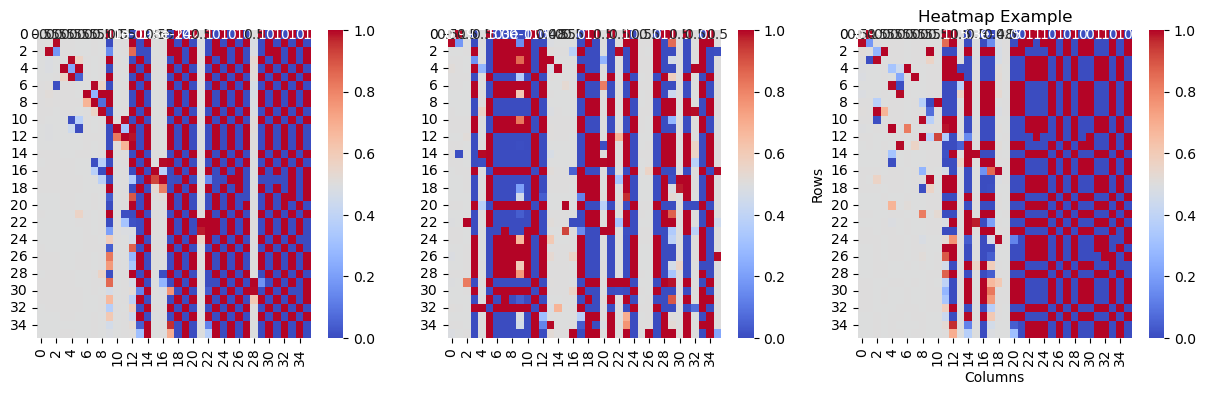

In [4]:
default_basis = [1,2]
other_basis = np.setdiff1d(range(N), default_basis)
mixed_idx = np.array(default_basis) # add the coordinate basis as default.
rand_temp = np.random.permutation(other_basis)
mixed_idx = np.append(mixed_idx, rand_temp)

K_approx_one = K_approx[:,:,M_max-1]
K_approx_one = 1/dt * (np.squeeze(K_approx_one) - np.identity(N))

eig_v_pre = kp.pagerank(abs(K_approx_one), 50000, 0.7)
eig_v = eig_v_pre[other_basis]
eig_v2_pre = kp.subsampled_pagerank(abs(K_approx_one), 50000, 0.7, 0.3)
eig_v2 = eig_v2_pre[other_basis]


ranked_idx = np.array(default_basis) # add the coordinate basis as default.
ranked_idx2 = np.array(default_basis) # add the coordinate basis as default.

ranked_idx = np.append(ranked_idx, other_basis[np.argsort(eig_v)[::-1]])
ranked_idx2 = np.append(ranked_idx2, other_basis[np.argsort(eig_v2)[::-1]])

K_approx_one_mx = K_approx_one[np.ix_(mixed_idx,mixed_idx)]
# K_approx_one_mx = 1/dt * (np.squeeze(K_approx_one_mx) - np.identity(N))

K_approx_one_pr = K_approx_one[np.ix_(ranked_idx,ranked_idx)]
# K_approx_one_pr = 1/dt * (np.squeeze(K_approx_one_pr) - np.identity(N))

K_approx_one_subpr = K_approx_one[np.ix_(ranked_idx2,ranked_idx2)]
# K_approx_one_subpr = 1/dt * (np.squeeze(K_approx_one_subpr) - np.identity(N))

# Create a heatmap
#fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
fig1, ax1 = plt.subplots(1,3,figsize = (15,4))
#plt.figure(figsize=(8, 6))
color_scale = 5
sns.heatmap(expit(K_approx_one*color_scale), ax=ax1[0], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(K_approx_one_mx*color_scale), ax=ax1[1], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(K_approx_one_pr*color_scale), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)# sns.heatmap(expit(data_subpr*10), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(expit(K_approx_one_pr*100), annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(1/(1+np.exp(-K_approx_one)), annot=True, cmap='coolwarm', cbar=True)

# Add title and labels
plt.title("Heatmap Example")
plt.xlabel("Columns")
plt.ylabel("Rows")


In [5]:
# Computing the subspace angles with increasing number of (ordered) basis functions.

subsp_ang_mx = np.zeros(N)
subsp_ang_inc = np.zeros(N)
subsp_ang_pr = np.zeros(N)
subsp_ang_subpr = np.zeros(N)

M_ang = 1000
dataX_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
dataY_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
Psi_X_ang = np.zeros([M_ang,N])
Psi_Y_ang = np.zeros([M_ang,N])

for i in range(M_ang):
    dataY_for_angle[:,i] = kp.Duffing(dataX_for_angle[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)

for i in range(M_ang):
    if orth_basis==True:
        Psi_X_ang[i,:], ind_mat = kp.psi_Laguerre(dataX_for_angle[:,i], d, max_order)
        Psi_Y_ang[i,:] = kp.psi_Laguerre(dataY_for_angle[:,i], d, max_order)[0]
    else:
        Psi_X_ang[i,:], ind_mat = kp.psi_d2(dataX_for_angle[:,i], max_order)
        Psi_Y_ang[i,:] = kp.psi_d2(dataY_for_angle[:,i], max_order)[0]
    
for N_vary in range(2,N):
    # x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    # Psi_Y_ang = np.matmul(Psi_X_ang[np.ix_(range(M_ang),range(N_vary))], data[np.ix_(range(N_vary),range(N_vary))])
    subsp_ang_inc[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),range(N_vary))], Psi_Y_ang[np.ix_(range(M_ang),range(N_vary))])[0]
    subsp_ang_mx[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),mixed_idx[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),mixed_idx[range(N_vary)])])[0]
    subsp_ang_pr[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),ranked_idx[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),ranked_idx[range(N_vary)])])[0]
    subsp_ang_subpr[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),ranked_idx2[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),ranked_idx2[range(N_vary)])])[0]



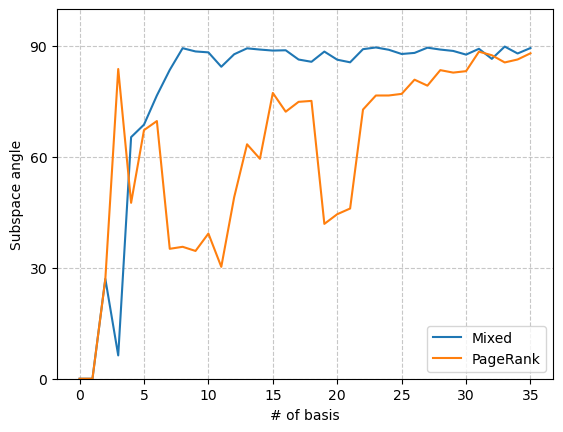

In [6]:
# plt.plot(subsp_ang_inc * 180/np.pi)
plt.plot(subsp_ang_mx * 180/np.pi)
plt.ylim([0, 100])
plt.yticks([0, 30, 60, 90])
plt.xlabel("# of basis")
plt.ylabel("Subspace angle")
plt.plot(subsp_ang_pr * 180/np.pi)
# plt.plot(subsp_ang_subpr * 180/np.pi)
# plt.xlabel("Basis functions")
# plt.ylabel("PageRank")
plt.legend(["Mixed", "PageRank", "Sub-PageRank"])
plt.grid(True, linestyle='--', alpha=0.7)


In [7]:
# Computing the error function by evoling a function with the true dynamics and approximated dynamics.
# Error: ||K^n[g] - K_{approx}^n[g]||

# Fix the number of observables used to make 
N_reconst = 10

common_obs = set(mixed_idx[range(N_reconst)]) & set(ranked_idx[range(N_reconst)]) # list of common observables
print(common_obs)
K_sub_mixed = K_approx_one[np.ix_(mixed_idx[range(N_reconst)],mixed_idx[range(N_reconst)])]
K_sub_PR = K_approx_one[np.ix_(ranked_idx[range(N_reconst)],ranked_idx[range(N_reconst)])]

# K_reapprox_mixed = K_approx_one[np.ix_(mixed_idx[range(N_reconst)],mixed_idx[range(N_reconst)])]
# K_reapprox_PR = K_approx_one[np.ix_(ranked_idx[range(N_reconst)],ranked_idx[range(N_reconst)])]


M_error = 1000
# dataX_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
# dataY_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
dataX_for_error = np.random.default_rng(14).uniform(-2, 2, size=(d, M_error))

Psi_X_max_budget = np.zeros([M_error,N])
# Psi_X_mixed = np.zeros([M_error,N_reconst])
# Psi_X_PR = np.zeros([M_error,N_reconst])

for i in range(M_error):
    if orth_basis == True:
        Psi_X_max_budget[i,:] = kp.psi_Laguerre(dataX_for_error[:,i], d, max_order)[0]
    else:
        Psi_X_max_budget[i,:] = kp.psi_d2(dataX_for_error[:,i], max_order)[0]
Psi_X_mixed = Psi_X_max_budget[np.ix_(range(M_error), mixed_idx[range(N_reconst)])] 
Psi_X_PR = Psi_X_max_budget[np.ix_(range(M_error), ranked_idx[range(N_reconst)])] 




{1, 2, 10, 7}


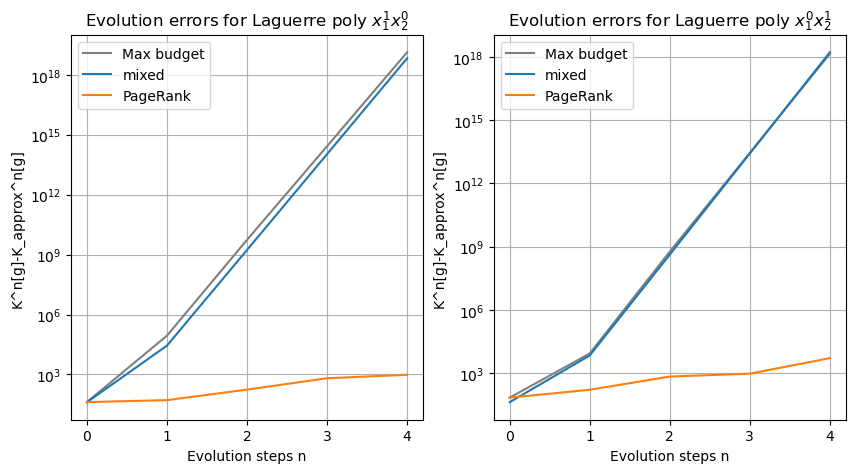

In [13]:
# Pick one `g_test' of the common observables

# plt.figure()
fig, ax = plt.subplots(1, np.size(default_basis), figsize=(10, 5))
fig_id = 0
for g_test_id in default_basis:
    # break
# g_test_id=0
# We need to find the index label corresponding to the chosen observable g_test from mixed_idx and ranked_idx, respectively.
    mix_idx = np.where(mixed_idx == g_test_id)[0][0]
    PR_idx = np.where(ranked_idx == g_test_id)[0][0]

    dataY_for_error = dataX_for_error
    Psi_Y_max_budget = Psi_X_max_budget
    Psi_Y_mixed = Psi_X_mixed
    Psi_Y_PR = Psi_X_PR
    g_eval_full = np.zeros(M_error)

    evolve_max = 5
    error_list_max_budget = np.zeros(evolve_max)
    error_list_mixed = np.zeros(evolve_max)
    error_list_PR = np.zeros(evolve_max)

    for n_evolve in range(evolve_max):
        for i in range(M_error):
            dataY_for_error[:,i] = kp.Duffing(dataY_for_error[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)
            if orth_basis == True:
                g_eval_full[i] = kp.psi_Laguerre(dataY_for_error[:,i], d, max_order)[0][g_test_id]
                g_poly_id = kp.psi_Laguerre(dataY_for_error[:,i], d, max_order)[1][g_test_id]
            else:
                g_eval_full[i] = kp.psi_d2(dataY_for_error[:,i], max_order)[0][g_test_id]
                g_poly_id = kp.psi_d2(dataY_for_error[:,i], max_order)[1][g_test_id]
        Psi_Y_max_budget = np.matmul(Psi_Y_max_budget, K_approx_one)
        
        # print(Psi_Y_mixed[range(10),0])
        # print(Psi_Y_PR[range(10),0])
        
        Psi_Y_mixed = np.matmul(Psi_Y_mixed, K_sub_mixed)
        Psi_Y_PR = np.matmul(Psi_Y_PR, K_sub_PR)

        g_eval_max_budget = Psi_Y_max_budget[:,g_test_id]
        g_eval_mixed = Psi_Y_mixed[:,mix_idx]
        g_eval_PR = Psi_Y_PR[:,PR_idx]

        error_list_max_budget[n_evolve] = np.linalg.norm(g_eval_max_budget - g_eval_full)
        error_list_mixed[n_evolve] = np.linalg.norm(g_eval_mixed - g_eval_full)
        error_list_PR[n_evolve] = np.linalg.norm(g_eval_PR - g_eval_full)

    
    ax[fig_id].semilogy(error_list_max_budget, color = "tab:gray")
    ax[fig_id].set_xlabel("Evolution steps n")
    ax[fig_id].set_ylabel("K^n[g]-K_approx^n[g]")
    ax[fig_id].semilogy(error_list_mixed, color = "tab:blue")
    ax[fig_id].semilogy(error_list_PR, color = "tab:orange")
    # plt.xlabel("Basis functions")
    # plt.ylabel("PageRank")
    ax[fig_id].legend(["Max budget", "mixed", "PageRank"])
    ax[fig_id].set_xticks(range(evolve_max))
    ax[fig_id].set_title('Evolution errors for Laguerre poly '+ rf"$x_1^{g_poly_id[0]}$" + rf"$x_2^{g_poly_id[1]}$")
    ax[fig_id].grid(True)
    fig_id += 1
plt.show()

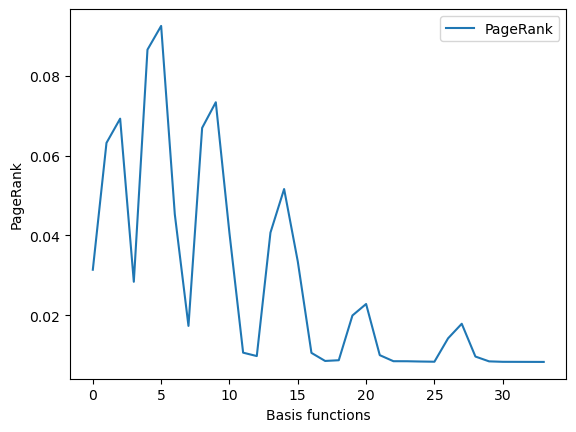

In [67]:
plt.plot(eig_v)
plt.xlabel("Basis functions")
plt.ylabel("PageRank")
# plt.plot(eig_v2)
# plt.xlabel("Basis functions")
# plt.ylabel("PageRank")
plt.legend(["PageRank", "Subsampled PageRank"])



[-6.05904882e-08  1.41862858e-08  3.53769503e-10  5.86317147e-11
  2.70047547e-08 -2.19636611e-11  8.99601888e-10 -4.84895514e-11
 -1.70153714e-09  1.26807163e-08]
[-6.05904882e-08  1.41862858e-08  2.70047547e-08  1.59643017e-08
 -8.44330129e-09 -2.18312026e-08  3.53769503e-10 -1.02816461e-08
  4.72087224e-09  2.00699427e-08]


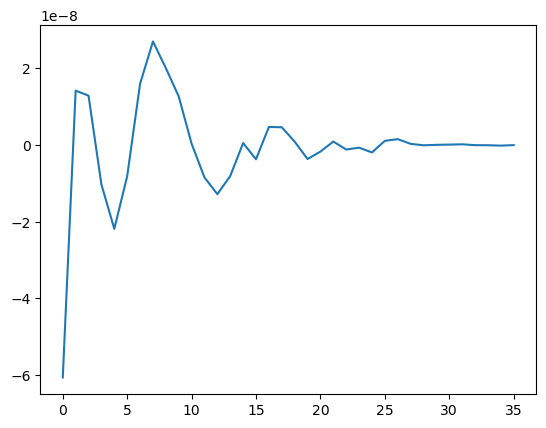

In [109]:
# print(ranked_idx[range(N_reconst)])
# print(mixed_idx[range(N_reconst)])

# for i in ranked_idx:
#     print(ind_mat[i])
print(K_sub_mixed[:,0][range(10)])
print(K_sub_PR[:,0][range(10)])
# print(K_approx_one_subpr[:,0][range(10)])
plt.plot(K_approx_one[:,0])
# plt.plot(Psi_X_mixed)

In [107]:
Psi_Y_PR.shape

(1000, 10)

In [73]:
# print(g_eval_full[range(10)])
# print(g_eval_PR[range(10)])
print(g_eval_mixed[range(10)])
print(g_eval_max_budget[range(10)])
# g_poly_id



[-2.08337797e+12 -2.76029485e+11 -4.55225690e+11 -5.06781761e+12
 -6.92173572e+11  1.52618756e+11 -7.19440425e+11 -1.49337336e+11
  1.78491523e+11  1.35908732e+11]
[-1.12939182e+10  2.21584718e+12  4.72460844e+10 -1.74689245e+10
  5.60146693e+12 -3.79470402e+10  1.92498437e+10  5.11090833e+10
  3.54834358e+11 -4.36166723e+10]


In [147]:
np.size(default_basis)

2